In [1]:
print('Hello, world!')

Hello, world!


In [1]:
import pandas as pd
import numpy as np

# Đọc dữ liệu
df = pd.read_csv('hmeq-1.csv')

# Xác định các cột số (loại bỏ cột mục tiêu BAD)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('BAD')

# Điền giá trị thiếu cho các cột số bằng trung bình
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()))

# Điền giá trị thiếu cho các cột phân loại bằng một giá trị đặc biệt (ví dụ 'Unknown')
df['REASON'] = df['REASON'].fillna('Unknown')
df['JOB'] = df['JOB'].fillna('Unknown')

# One-hot encoding cho các cột phân loại (loại bỏ trường đầu để tránh đa cộng tuyến)
df_encoded = pd.get_dummies(df, columns=['REASON', 'JOB'], drop_first=True)

# Xem cấu trúc dữ liệu đã mã hóa
print("Kích thước dữ liệu sau mã hóa:", df_encoded.shape)
print(df_encoded.head())

Kích thước dữ liệu sau mã hóa: (5960, 19)
   BAD  LOAN     MORTDUE          VALUE        YOJ    DEROG    DELINQ  \
0    1  1100  25860.0000   39025.000000  10.500000  0.00000  0.000000   
1    1  1300  70053.0000   68400.000000   7.000000  0.00000  2.000000   
2    1  1500  13500.0000   16700.000000   4.000000  0.00000  0.000000   
3    1  1500  73760.8172  101776.048741   8.922268  0.25457  0.449442   
4    0  1700  97800.0000  112000.000000   3.000000  0.00000  0.000000   

        CLAGE      NINQ       CLNO    DEBTINC  REASON_HomeImp  REASON_Unknown  \
0   94.366667  1.000000   9.000000  33.779915            True           False   
1  121.833333  0.000000  14.000000  33.779915            True           False   
2  149.466667  1.000000  10.000000  33.779915            True           False   
3  179.766275  1.186055  21.296096  33.779915           False            True   
4   93.333333  0.000000  14.000000  33.779915            True           False   

   JOB_Office  JOB_Other  JOB_Pr

In [2]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['BAD'])
y = df_encoded['BAD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (4768, 18)
Kích thước tập kiểm tra: (1192, 18)


In [4]:
from lightgbm import LGBMClassifier

# Khởi tạo và huấn luyện mô hình LightGBM
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 951, number of negative: 3817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 4768, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199455 -> initscore=-1.389706
[LightGBM] [Info] Start training from score -1.389706


LGBMClassifier(random_state=42)

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"Độ chính xác trên tập kiểm tra: {acc:.4f}")

# Báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
print("Ma trận nhầm lẫn:")
print(cm)

Độ chính xác trên tập kiểm tra: 0.9169
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       954
           1       0.87      0.68      0.77       238

    accuracy                           0.92      1192
   macro avg       0.90      0.83      0.86      1192
weighted avg       0.91      0.92      0.91      1192

Ma trận nhầm lẫn:
[[930  24]
 [ 75 163]]


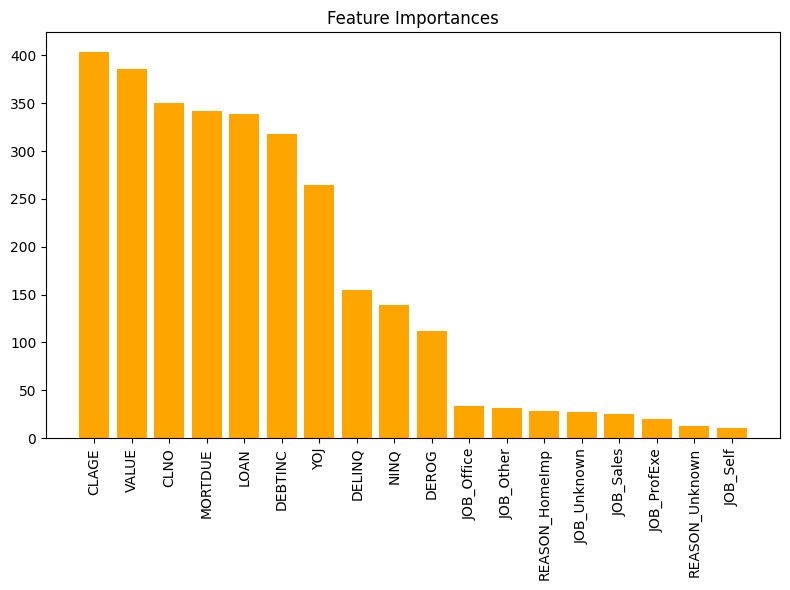

In [7]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

# Sắp xếp theo độ quan trọng giảm dần
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = feature_names[indices]

plt.figure(figsize=(8,6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances, color='orange')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# 🔍 Kiểm tra overfitting
train_acc = accuracy_score(y_train, model.predict(X_train))
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

In [ ]:
# 📊 Tính ROC-AUC và vẽ đường cong ROC
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

### 🚀 Gợi ý tiếp theo: Tối ưu tham số bằng `GridSearchCV` hoặc `RandomizedSearchCV`
Bạn có thể dùng đoạn mã sau để tìm tham số tốt nhất:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
}

grid = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation AUC:", grid.best_score_)